In [3]:
# I will try and import just base libraries so you can see from which package the different functions come from
import torch
import torchvision
import typing

# Loading the Data

## The easy way

It turns out, the fashion mnist dataset is directly available from the torchvision.datasets library! The easiest way to load the dataset would be taking advantage of that library

In [4]:
training_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=torchvision.transforms.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)),
)

test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=torchvision.transforms.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)),
)

100.0%


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100.0%


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100.0%


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100.0%

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



However, not every dataset will be available through a library. In that case, you will have to download the dataset yourself, and create your OWN dataset class that handles the data. Let's take a look at how to do that below. Running the cells above would have downloaded the data into a new folder called data, which we'll parse manually.

## The Hard Way

First, let's use the gzip library to convert the files downloaded previously into numpy arrays. If you haven't run the cells above, please do so.

In [5]:
import os
import gzip
import numpy as np

def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 1, 28, 28)

    return images, labels

X_train, y_train = load_mnist('data/FashionMNIST/raw/', kind='train')
X_test, y_test = load_mnist('data/FashionMNIST/raw/', kind='t10k')

print('train data shape: ', X_train.shape)
print('test data shape: ', X_test.shape)

train data shape:  (60000, 1, 28, 28)
test data shape:  (10000, 1, 28, 28)


As long as you can get you data to numpy arrays, you are good to go! When dealing with data such as text, there is a special step called [tokenization](https://huggingface.co/docs/transformers/tokenizer_summary) which you have to do first. However, that is much more advanced and beyond the scope of this tutorial.

Now we will create a pytorch dataset class using the numpy arrays we created. When passing input to pytorch models, these models always work with pytorch tensors and not any other type of matrices. This means we will have to build torch tensors (via `torch.Tensor(...)` and `torch.LongTensor`) from each of our numpy arrays. Notice when using the torchvision dataset we pass in a transform `torchvision.transforms.ToTensor()`. That automatically handles converting our matrix to `torch.Tensor` format.

In [6]:
# it is important our custom class subclasses the Dataset class
class CustomFashinMNSITDataset(torch.utils.data.Dataset):
    def __init__(self, X: torch.Tensor, y: torch.Tensor) -> None:
        self.X = X
        self.y = y

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self, index: int) -> typing.Tuple[torch.Tensor, torch.Tensor]:
        return self.X[index], torch.zeros(10, dtype=torch.float).scatter_(0, self.y[index], value=1)

training_data = CustomFashinMNSITDataset(torch.Tensor(X_train), torch.LongTensor(y_train))
test_data = CustomFashinMNSITDataset(torch.Tensor(X_test), torch.LongTensor(y_test))

/var/folders/g9/294r07312xs27rdfv4kz7zpm0000gn/T/ipykernel_10243/3062027500.py:13: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666646603923/work/torch/csrc/utils/tensor_numpy.cpp:205.)
  training_data = CustomFashinMNSITDataset(torch.Tensor(X_train), torch.LongTensor(y_train))


Regardless of how we create the dataset, we now have a Dataset object. Using this we create a data loader class. This will handle iterating over "batches" (small chunks of the dataset) to train our model. We could loop over each individual data point one by one, but people have found that training in **batches** tends to be more effective. Essentially, we take a batch of say 64 random examples left in our dataset, compute the predictions for them, and then edit the weights using all 64 predictions. This helps the model to **generalize** to new data. One example at a time (batch size of 1) would make very extreme changes as one example is not very representative of the dataset. It would also be incredibly ineffecient. Lots of example is quite efficient, but does not give the model to learn as much from each mistake, it is sort of recieving feedback on a project all at once vs little by little in digestable chunks.

In [7]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Let's take a quickly look at a the size of our first batch, and the very first image in the batch.

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64, 10])


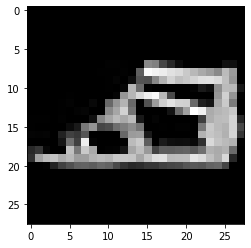

Label: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])


In [57]:
import matplotlib.pyplot as plt

# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

Notice that our label tensor is not just a value in [0,9]. It is an array of 0's, with a 1 at the INDEX of the label. This is because rather than have a single output predict one continuous value that is between 0 and 10, we can have ten output nodes each predict one class. More concretely, these are the labels for fashion mnist:
| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

However, can we add 1 to trouser to get pullover? Can we subtract 3 from sandal and get dress? No, although a single continuous label value might make more sense in our minds, the continuity of the label space has relationships that we DON'T want. So by splitting it up into 10 different labels, we can avoid this implicity relationships.

That's plenty of talking about datasets, let's get on to building the model!

# Building the Model

Once again, we can build our model in a super simple and quick way, or a much more tedious version. As usual, the simple way does not offer as much flexibility as the hard way but is still useful to know of.

## The Easy Way

In [ ]:
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(28 * 28, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 10),
)

This is pretty straight forward implementation. This `torch.nn.Sequential` is a wrapper that forward the input through each layer in the order you pass them in. In our case, the model will first flatten the input, then pass it through a linear layer that changes the last dimension from 28*28 to 512, etc.

## The Tedious Way

In [ ]:
class FashionMnistClassifier(torch.nn.Module):
    def __init__(self):
        super(FashionMnistClassifier, self).__init__()
        self.flatten = torch.nn.Flatten()
        self.linear_relu_stack = torch.nn.Sequential(
            torch.nn.Linear(28*28, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = FashionMnistClassifier()

What we have done here is placed different layers into instance variables in the `__init__` function. Now, we override the forward function, that given an input vector x, spits out the output. Since we replicating the same behavoir as the easy way, we just pass x through flatten, then pass it through our `linear_rule_stack`. However, defining your own forward function helps for building more complex forward passes. This definitely isn't harder, but it can be more tedious. I would say this is always worth the extra effort though for readability and flexibility. You can notice we actually used `torch.nn.Sequential` inside our class, which is a module like any other. This means we can call module(x) and it will pass x to the forward method.

# Training

Now we are onto the final step of the model, and here there is no easy way vs other way. There really is just one well defined format we will use to train our model.

There are three key elements to training our model:

    - Loss Function
    - Optimizer
    - Training Loop

## Loss Function

Defining the loss function is pretty easy in pytorch. At a high level, you pass in two arrays, the model's predictions and the ground truths. For each example, you compare the prediction and ground truth and compute some sort of "loss" value. Essentially, the higher loss value, the worse your model did. The training process adjusts the weights of the model in order to minimize the loss value, so it is important to make sure you select the correct loss function.

While we can also build our own loss function pretty quickly, PyTorch has almost every popular loss function you could think of built into it already. We will use the built in CrossEntropyLoss function.

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()

## Optimizer

This is the algorithm that will optimize the parameters in our neural network so that our model actually **learns**. These are a lot more complex than loss functions. Optimizers make use of partial derivatives and momentum to optimally minimize the loss function. Partial derivatives help to identify which parameters contributed most to a large loss. At a high level, this informs the optimizer which parameters need to be adjusted and which can be left alone. Momentum helps to avoid settling at local minima and instead settle at global minima. Part of deciding the "moentum" portion of an optimizer is the **learning rate**. Too slow of a learning rate and your model will take forever to train and get stuck at local minima. Too high of a learning rate and your model's loss could spiral out of control.

We will be using the simple `Stochastic Gradient Descent` (aka SGD) algorithm, but the modern, state of the art optimizer most people use is called `Adam`. It should be noted though that while `Adam` is a great all round optimizer, different optimizers are better suited for different tasks.

In [ ]:
learning_rate = 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## Training Loop

After selecting the appropriate loss function and optimizer, we need to iterate over our dataset, and train the model using all the points in the dataset in batches that we defined when we previously created our DataLoader. We also need to define how many times we want to loop over the dataset when we train. It is often more helpful to look over the entire dataset multiple times for the model to better understand it. This is called the number of **epochs**.

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
epochs = 5
for i in range(epochs):
    print(f"Epoch {i+1}")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)

## Inference

Now that we have trained and tested our model, we can use it to classify our own new examples! Draw your own 28x28 pixel grayscale image, load it, and see what our model says!

## Save and load the model for future use

It is best practice to save just the model weights to a file. This ensure that when you recreate the model and load the weights, you have actually recreated the correct model. You can also save the whole model file object and load it, however since this doesn't require you to instantiate the model you may not load the correct model, and have no way of knowing whether you did or not. By instantiating the model first and directly loading the weights you can ensure that the correct model has been created, even if it is a bit more work.

Saving the model is pretty easy and can be done in a single line. Just get the state dict, and save it with the built in `torch.save` method.

In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')

Now we can load the weights into a new instance of the same type of model

In [ ]:
model2 = FashionMnistClassifier()
model.load_state_dict(torch.load('model_weights.pth'))

In case you are curious, here is how you would irectly save and load the model:

In [ ]:
torch.save(model, 'model.pth')
# Notice how we have no idea what the model parameters are since it's
# inside a file. We can load it into any variable name we want.
model3 = torch.load('model.pth')